In [1]:
# default_exp raster_zonal_stats

In [2]:
# hide
# no_test
! [ -e /content ] && pip install -Uqq geowrangler

In [3]:
# hide
# no_test
!mkdir -p ../data
![ -e /content ] && ln -s ../data .

In [4]:
# hide
# no_test
!mkdir -p ../data
# download sample geojson files from repo
![ ! -e ../data/sample_terrain.tif ] && curl -s -o ../data/sample_terrain.tif https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/sample_terrain.tif
![ ! -e ../data/region3_admin.geojson ] && curl -s -o ../data/region3_admin.geojson https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/region3_admin.geojson
# originally from https://data.worldpop.org/GIS/Population/Global_2000_2020_Constrained/2020/BSGM/PHL/phl_ppp_2020_constrained.tif
![ ! -e ../data/phl_ppp_2020_constrained.tif ] && curl -s -o ../data/phl_ppp_2020_constrained.tif https://raw.githubusercontent.com/thinkingmachines/geowrangler/master/data/phl_ppp_2020_constrained.tif

In [5]:
# hide
# no_test
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Raster Zonal Stats

> generating zonal stats from raster data

Note: This module is a thin layer on top of the `rasterstats` package to make its interface more compatible with the other geowrangler modules (e.g. vector zonal stats)

In [6]:
# export
from pathlib import Path
from typing import Any, Dict, Union

import geopandas as gpd
import pandas as pd
import rasterio
import rasterstats as rs

from geowrangler.vector_zonal_stats import _expand_aggs, _fillnas, _fix_agg

In [7]:
# export
def create_raster_zonal_stats(
    aoi: Union[  # The area of interest geodataframe, or path to the vector file
        str, gpd.GeoDataFrame
    ],
    data: Union[str, Path],  # The path to the raster data file
    aggregation: Dict[  # A dict specifying the aggregation. See `create_zonal_stats` from the `geowrangler.vector_zonal_stats` module for more details
        str, Any
    ],
    extra_args: Dict[  # Extra arguments passed to `rasterstats.zonal_stats` method
        str, Any
    ] = dict(
        layer=0,
        band_num=1,
        nodata=None,
        affine=None,
        all_touched=False,
    ),
) -> gpd.GeoDataFrame:

    """Compute zonal stats with a vector areas of interest (aoi) from raster data sources.
    This is a thin layer  over the `zonal_stats` method from
    the `rasterstats` python package for compatibility with other geowrangler modules.
    This method currently only supports 1 band for each call, so if you want to create zonal
    stats for multiple bands with the same raster data, you can call this method for
    each band (make sure to specify the correct `band_num` in the `extra_args` parameter).
    See https://pythonhosted.org/rasterstats/manual.html#zonal-statistics for more details"""
    fixed_agg = _fix_agg(aggregation)

    if "stats" in extra_args:
        extra_args.pop("stats")  # use aggregation

    if "geojson_out" in extra_args:
        extra_args.pop("geojson_out")  # never add features

    if "categorical" in extra_args:
        extra_args.pop("categorical")  # no use for categorical and categorical maps
    if "categorical_map" in extra_args:
        extra_args.pop("categorical_map")

    if "prefix" in extra_args:
        extra_args.pop("prefix")  # use agg['column'] as prefix

    if "add_stats" in extra_args:
        extra_args.pop("add_stats")  # always use stats only

    if "nodata" in extra_args:
        nodata = extra_args["nodata"]
        if nodata is None:
            extra_args.pop("nodata")
            with rasterio.open(data) as src:
                extra_args["nodata"] = src.nodata

    stats = fixed_agg["func"]
    prefix = fixed_agg["column"] + "_"

    renamed_columns = {
        f"{prefix}{func}": fixed_agg["output"][i]
        for (i, func) in enumerate(fixed_agg["func"])
        if f"{prefix}{func}" != fixed_agg["output"][i]
    }
    results_dict = rs.zonal_stats(
        vectors=aoi,
        raster=data,
        stats=stats,
        geojson_out=False,
        categorical=False,
        category_map=None,
        prefix=prefix,
        **extra_args,
    )

    results = pd.DataFrame.from_records(results_dict)
    results.rename(columns=renamed_columns, inplace=True)
    expanded_aggs = _expand_aggs([fixed_agg])

    if type(aoi) == str:
        aoi = gpd.read_file(aoi)

    _fillnas(expanded_aggs, results, aoi)

    aoi = aoi.merge(results, how="left", left_index=True, right_index=True)

    return aoi

In [8]:
# hide
# see tests/test_vector_zonal_stats.py
from shapely.geometry import Polygon


def make_simple_aoi():
    df = pd.DataFrame(
        data={
            "col1": [1, 2, 3],
            "lat0": [0.0, 1.0, 2.0],
            "lon0": [0.0, 0.0, 0.0],
            "lat1": [0.0, 1.0, 2.0],
            "lon1": [1.0, 1.0, 1.0],
            "lat2": [1.0, 2.0, 3.0],
            "lon2": [1.0, 1.0, 1.0],
            "lat3": [1.0, 2.0, 3.0],
            "lon3": [0.0, 0.0, 0.0],
        }
    )

    def square(row):
        return Polygon(
            (
                [
                    (row.lat0, row.lon0),
                    (row.lat1, row.lon1),
                    (row.lat2, row.lon2),
                    (row.lat3, row.lon3),
                ]
            )
        )

    return gpd.GeoDataFrame(df, geometry=df.apply(square, axis=1), crs="EPSG:4326")


simple_aoi = make_simple_aoi()
terrain_file = "../data/sample_terrain.tif"

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio

In [10]:
with rasterio.open(terrain_file) as src:
    data = src.read(1)
    data_crs = src.crs
    data_bounds = src.bounds
print(data.shape, data_crs, data_bounds)

(707, 707) EPSG:3857 BoundingBox(left=-20.0, bottom=-19.994, right=19.994, top=20.0)


In [11]:
simple_aoi.total_bounds

array([0., 0., 3., 1.])

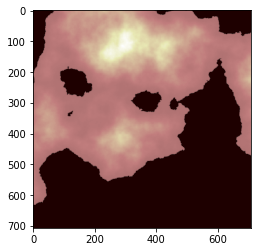

In [12]:
ax = plt.imshow(data, cmap="pink")

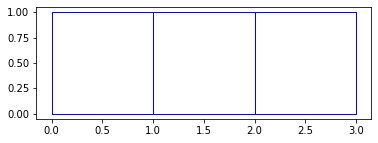

In [13]:
ax = simple_aoi.plot(facecolor="none", edgecolor="blue")

In [14]:
%%time
results = create_raster_zonal_stats(
    simple_aoi,
    terrain_file,
    aggregation=dict(func=["mean", "max", "min", "std"], column="elevation"),
    extra_args=dict(nodata=np.nan),
)

CPU times: user 18.5 ms, sys: 39.4 ms, total: 58 ms
Wall time: 19 ms


In [15]:
results

,col1,lat0,lon0,lat1,lon1,lat2,lon2,lat3,lon3,geometry,elevation_min,elevation_max,elevation_mean,elevation_std
0,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,"POLYGON ((0.00000 0.00000, 0.00000 1.00000, 1....",1238.734161,1444.722213,1339.126726,64.362218
1,2,1.0,0.0,1.0,1.0,2.0,1.0,2.0,0.0,"POLYGON ((1.00000 0.00000, 1.00000 1.00000, 2....",1222.409102,1425.920852,1311.903997,51.286449
2,3,2.0,0.0,2.0,1.0,3.0,1.0,3.0,0.0,"POLYGON ((2.00000 0.00000, 2.00000 1.00000, 3....",1231.569771,1402.859628,1319.624868,45.298326


Check that `create_raster_zonal_stats` uses the `nodata` attribute set in the tif file if `extra_args.nodata` is set to `None`

In [23]:
# Load in admin bounds
phl_adm = gpd.read_file("../data/region3_admin.geojson")

If the `nodata` parameter is explicitly set to `-999999`, the Population count should be > 0.

In [24]:
grid_aoi_results = create_raster_zonal_stats(
    phl_adm,
    "../data/phl_ppp_2020_constrained.tif",
    aggregation=dict(
        func=["sum"],
        column="population",
        output=["population_count"],
        fillna=[True],
    ),
    extra_args=dict(nodata=-99999),
)

In [25]:
grid_aoi_results

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,population_count
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",10983338.0


In [26]:
# hide
assert grid_aoi_results["population_count"].iloc[0] > 0

If  the `nodata` parameter is not set, `create_raster_zonal_stats` should use the `nodata` attribute set by the geotiff file so that population count should still be > 0.

In [27]:
grid_aoi_results = create_raster_zonal_stats(
    phl_adm,
    "../data/phl_ppp_2020_constrained.tif",
    aggregation=dict(
        func=["sum"],
        column="population",
        output=["population_count"],
        fillna=[True],
    ),
)

In [28]:
# hide
assert grid_aoi_results["population_count"].iloc[0] > 0

In [22]:
grid_aoi_results

,Reg_Code,Reg_Name,Reg_Alt_Name,geometry,population_count
0,030000000,Region III,Central Luzon,"MULTIPOLYGON (((120.11687 14.76309, 120.11684 ...",10983338.0
